In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
from utility_functions import *

In [2]:
def read_data(sample_name):
    path = '/project01/ndcms/cmoore24/skims/skimmed_jets/mc/nolepton/tagged'
    dir_contents = os.listdir(path)
    wanted_samples = []
    for i in dir_contents:
        if sample_name in i:
            wanted_samples.append(i)
    sample_dict = {}
    for i in wanted_samples:
        sample_dict[f'{i.replace(".parquet", "")}'] = ak.from_parquet(f'{path}/{i}')
    return sample_dict

In [3]:
mc = {}
mc['zqq'] = read_data('zqq')
mc['wqq'] = read_data('wqq')
mc['ttboosted']= read_data('ttboosted')
mc['diboson'] = read_data('diboson')
mc['hbb'] = read_data('hbb')
mc['hgg'] = read_data('hgg')
mc['qcd'] = read_data('qcd')
mc['singletop'] = read_data('singletop')

In [4]:
def nan_remover(sample):
    if type(sample) == dict:
        for j in sample:
            mask = ak.ones_like(sample[j][sample[j].fields[0]], dtype='bool')
            mask = ak.fill_none(mask, True)
            for k in sample[j].fields:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
            sample[j] = sample[j][mask]
    else:
        mask = ak.ones_like(sample[sample.fields[0]], dtype='bool')
        mask = ak.fill_none(mask, True)
        for j in sample.fields:
            if sample[j].fields == []:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j])))
            else:
                for k in sample[j].fields:
                    mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
        sample = sample[mask]
    return sample

In [5]:
mc_jets = {}
for i in mc:
    mc_jets[i] = {}
    for j in mc[i]:
        mc_jets[i][j] = nan_remover(mc[i][j].goodjets)

In [6]:
mc_jets['hbb']['hbb'].btag_count

<Array [1, 4, 1, 1, 1, 4, 1, 2, ..., 2, 1, 2, 3, 2, 2, 1] type='6993 * ?int64'>

In [7]:
for i in mc_jets:
    for j in mc_jets[i]:
        mc_jets[i][j] = mc_jets[i][j][mc_jets[i][j].btag_count == 0]

In [8]:
mc_jets['hbb']['hbb'].btag_count

<Array [0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0] type='184 * ?int64'>

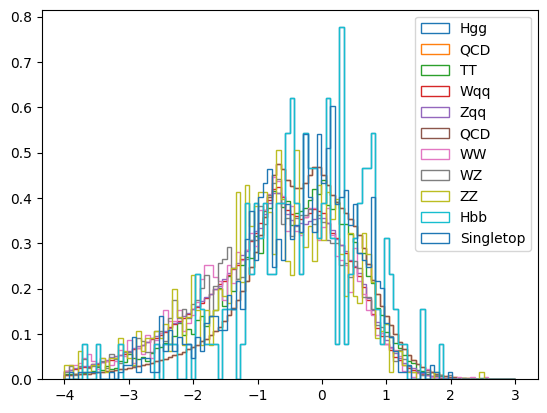

In [9]:
pltrange = (-4, 3)
plt.hist(mc_jets['hbb']['hbb'].ecf_tagger, bins=100, histtype='step', density=True, label='Hgg', range=pltrange)
plt.hist(mc_jets['qcd']['qcd_470to600'].ecf_tagger, bins=100, histtype='step', density=True, label='QCD', range=pltrange)
plt.hist(mc_jets['ttboosted']['ttboosted_700to1000'].ecf_tagger, bins=100, histtype='step', density=True, label='TT', range=pltrange)
plt.hist(mc_jets['wqq']['wqq_800toInf'].ecf_tagger, bins=100, histtype='step', density=True, label='Wqq', range=pltrange)
plt.hist(mc_jets['zqq']['zqq_800toInf'].ecf_tagger, bins=100, histtype='step', density=True, label='Zqq', range=pltrange)
plt.hist(mc_jets['qcd']['qcd_470to600'].ecf_tagger, bins=100, histtype='step', density=True, label='QCD', range=pltrange)
plt.hist(mc_jets['diboson']['diboson_ww'].ecf_tagger, bins=100, histtype='step', density=True, label='WW', range=pltrange)
plt.hist(mc_jets['diboson']['diboson_wz'].ecf_tagger, bins=100, histtype='step', density=True, label='WZ', range=pltrange)
plt.hist(mc_jets['diboson']['diboson_zz'].ecf_tagger, bins=100, histtype='step', density=True, label='ZZ', range=pltrange)
plt.hist(mc_jets['hbb']['hbb'].ecf_tagger, bins=100, histtype='step', density=True, label='Hbb', range=pltrange)
plt.hist(mc_jets['singletop']['singletop'].ecf_tagger, bins=100, histtype='step', density=True, label='Singletop', range=pltrange)

plt.legend()
plt.show()

In [10]:
def sample_auc(bkg_name, scores):
    sample_aucs = {}
    bkg_zeros = ak.zeros_like(scores)
    sig_ones = ak.ones_like(mc_jets['hgg']['hgg'].ecf_tagger)
    combined = ak.concatenate([scores, mc_jets['hgg']['hgg'].ecf_tagger])
    combined_truth = ak.concatenate([bkg_zeros, sig_ones])
    fpr, tpr, thresholds = roc_curve(combined_truth, combined)
    roc_auc = auc(fpr, tpr)
    sample_aucs[i] = roc_auc
    return sample_aucs

In [11]:
aucs = {}
for i in mc_jets:
    if i == 'hgg':
        continue
    if type(mc_jets[i]) == dict:
        for j in mc_jets[i]:
            aucs[j] = sample_auc(j, mc_jets[i][j].ecf_tagger)
    else:
        aucs[i] = sample_auc(i, mc_jets[i].ecf_tagger)

/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


In [12]:
def roc_plot(bkg, signal, bkg_name):
    bkg_zeros = ak.zeros_like(bkg.ecf_tagger)
    sig_ones = ak.ones_like(signal.ecf_tagger)
    combined = ak.concatenate([bkg.ecf_tagger, signal.ecf_tagger])
    combined_truth = ak.concatenate([bkg_zeros, sig_ones])

    fpr, tpr, thresholds = roc_curve(combined_truth, combined)
    roc_auc = auc(fpr, tpr)

    hrange=(np.floor(ak.min(signal.ecf_tagger)), np.ceil(ak.max(signal.ecf_tagger)))

    hgg_hist = np.histogram(signal.ecf_tagger, bins=20,
                range=hrange
                )
    qcd_hist = np.histogram(bkg.ecf_tagger, bins=20, 
                     range=hrange
                    )

    sig_sums = []
    for i in range(len(hgg_hist[0])+1):
        sig_sums.append(sum(hgg_hist[0][len(hgg_hist[0])-i:]))
    
    bkg_sums = []
    for i in range(len(qcd_hist[0])+1):
        bkg_sums.append(sum(qcd_hist[0][len(qcd_hist[0])-i:]))

    sig_ratios = []
    for i in sig_sums:
        sig_ratios.append(i/sig_sums[-1])
    bkg_ratios = []
    for i in bkg_sums:
        bkg_ratios.append(i/bkg_sums[-1])

    wp_ratios = {}
    for i in range(len(hgg_hist[1])):
        wp_ratios[str(hgg_hist[1][-i-1])] = [sig_ratios[i], bkg_ratios[i]]

    plt.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
    plt.xlim([0, 1.0])
    #     ax.set_ylim([1e-5, 1.0])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title(f"Hgg receiver operating curve vs {bkg_name}")
    plt.legend(loc="lower right")
    plt.axvline(x=0.5, color='black')
    plt.axhline(y=0.5, color='black')
    for i in wp_ratios:
        plt.plot(wp_ratios[i][1], wp_ratios[i][0], 'o', label=f'WP = {str(i)}')
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

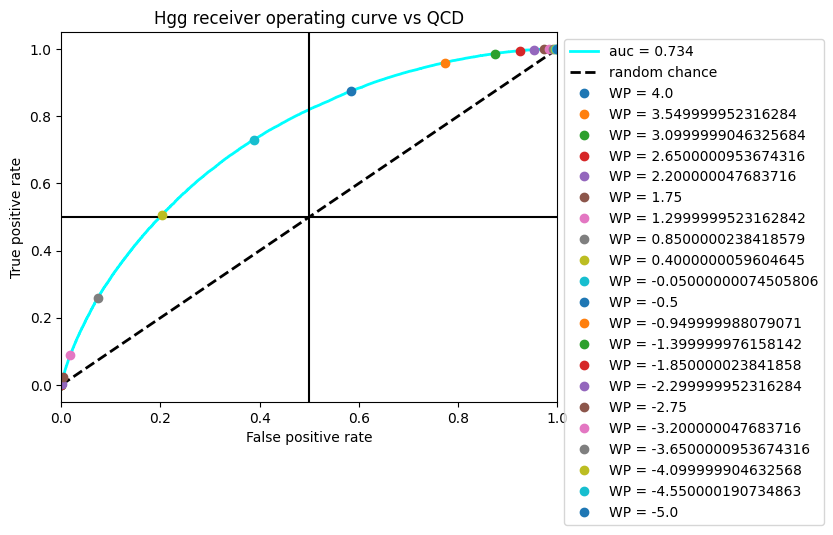

In [14]:
roc_plot(mc_jets['qcd']['qcd_470to600'], mc_jets['hgg']['hgg'], 'QCD')

In [15]:
def get_percentile_cut(data, target_percentile=0.50):
    data = np.array(data)
    cut_value = np.percentile(data, target_percentile * 100)
    return cut_value

In [16]:
cut = get_percentile_cut(mc_jets['hgg']['hgg'].ecf_tagger)
cut

0.4123387336730957

In [17]:
def bkg_output_hist(sample_name, wp, fail, sample_prefix=None):
    if sample_prefix != None:
        sample = mc_jets[sample_prefix][sample_name]
    else:
        sample = mc_jets[sample_name]
    
    if fail:
        mask = ~((sample.ecf_tagger >= wp))
        sample_cut_msd = sample.msoftdrop[mask]
    else:
        mask = (sample.ecf_tagger >= wp)
        sample_cut_msd = sample.msoftdrop[mask]
    try:
        msd_hist = hist.Hist.new.Reg(40, 80, 170, name=f"msd", label=f"MSD").Weight()
    except:
        msd_hist = hist.Hist.new.Reg(40, 80, 170, name=f"msd", label=f"MSD").Weight()
    msd_hist.fill(msd=sample_cut_msd)
    return msd_hist

In [78]:
pass_hists = {}
for i in mc_jets:
    if type(mc_jets[i]) == dict:
        for j in mc_jets[i]:
            msd_hist = bkg_output_hist(j, wp=cut, fail=False, sample_prefix=i)
            pass_hists[j] = msd_hist
    else:
        msd_hist = bkg_output_hist(i, wp=cut, fail=False)
        pass_hists[i] = msd_hist

In [79]:
fail_hists = {}
for i in mc_jets:
    if type(mc_jets[i]) == dict:
        for j in mc_jets[i]:
            msd_hist = bkg_output_hist(j, wp=cut, fail=True, sample_prefix=i)
            fail_hists[j] = msd_hist
    else:
        msd_hist = bkg_output_hist(i, wp=cut, fail=True)
        fail_hists[i] = msd_hist

In [80]:
with open('../jsons/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
del(totals['ww4q'])

In [81]:
with open('../jsons/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [82]:
scaleHgg = ((44.99*(xsecs['hgg']*1000)*0.0817)/(totals['hgg']))
fail_hists['hgg'].view(flow=True)[:] *= scaleHgg
pass_hists['hgg'].view(flow=True)[:] *= scaleHgg

In [83]:
scaleHbb = ((44.99*(xsecs['hbb']*1000)*0.579)/(totals['hbb']))
fail_hists['hbb'].view(flow=True)[:] *= scaleHbb
fail_hists['hbb'].view(flow=True)[:] *= scaleHbb

In [84]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [85]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [86]:
del(pass_hists['wqq_200to400'])
del(fail_hists['wqq_200to400'])

del(pass_hists['zqq_200to400'])
del(fail_hists['zqq_200to400'])

del(pass_hists['diboson_ww4q'])
del(fail_hists['diboson_ww4q'])

In [87]:
xsecs['diboson_ww'] = xsecs['ww']
xsecs['diboson_zz'] = xsecs['zz']
xsecs['diboson_wz'] = xsecs['wz']

totals['diboson_ww'] = totals['ww']
totals['diboson_zz'] = totals['zz']
totals['diboson_wz'] = totals['wz']

In [88]:
for i in pass_hists:
    if (i == 'hgg') or (i == 'hbb'):
        continue
    else:
        scale = ((44.99*(xsecs[i]*1000))/totals[i])
    pass_hists[i].view(flow=True)[:] *= scale

In [89]:
for i in fail_hists:
    if (i == 'hgg') or (i == 'hbb'):
        continue
    else:
        scale = ((44.99*(xsecs[i]*1000))/totals[i])
    fail_hists[i].view(flow=True)[:] *= scale

In [90]:
qcd_pass_hist = sum(value for key, value in pass_hists.items() if key.startswith('qcd')) *0.0001
qcd_fail_hist = sum(value for key, value in fail_hists.items() if key.startswith('qcd'))

wqq_pass_hist = sum(value for key, value in pass_hists.items() if key.startswith('wqq'))
wqq_fail_hist = sum(value for key, value in fail_hists.items() if key.startswith('wqq'))

zqq_pass_hist = sum(value for key, value in pass_hists.items() if key.startswith('zqq'))
zqq_fail_hist = sum(value for key, value in fail_hists.items() if key.startswith('zqq'))

ttboosted_pass_hist = sum(value for key, value in pass_hists.items() if key.startswith('ttboosted'))
ttboosted_fail_hist = sum(value for key, value in fail_hists.items() if key.startswith('ttboosted'))

In [91]:
pass_hists2 = {}
pass_hists2['qcd'] = qcd_pass_hist
pass_hists2['wqq'] = wqq_pass_hist
pass_hists2['zqq'] = zqq_pass_hist
pass_hists2['ttboosted'] = ttboosted_pass_hist
pass_hists2['ww'] = pass_hists['diboson_ww']
pass_hists2['wz'] = pass_hists['diboson_wz']
pass_hists2['zz'] = pass_hists['diboson_zz']
pass_hists2['singletop'] = pass_hists['singletop']
pass_hists2['hbb'] = pass_hists['hbb']
pass_hists2['hgg'] = pass_hists['hgg']
pass_hists = pass_hists2

In [92]:
fail_hists2 = {}
fail_hists2['qcd'] = qcd_fail_hist
fail_hists2['wqq'] = wqq_fail_hist
fail_hists2['zqq'] = zqq_fail_hist
fail_hists2['ttboosted'] = ttboosted_fail_hist
fail_hists2['ww'] = fail_hists['diboson_ww']
fail_hists2['wz'] = fail_hists['diboson_wz']
fail_hists2['zz'] = fail_hists['diboson_zz']
fail_hists2['singletop'] = fail_hists['singletop']
fail_hists2['hbb'] = fail_hists['hbb']
fail_hists2['hgg'] = fail_hists['hgg']
fail_hists = fail_hists2

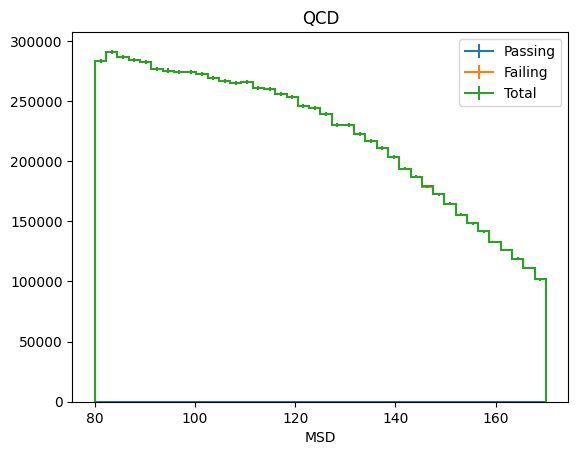

In [93]:
qcd_pass_hist.plot1d(density=False, label='Passing')
qcd_fail_hist.plot1d(density=False, label='Failing')
(qcd_pass_hist + qcd_fail_hist).plot1d(density=False, label='Total')
plt.title('QCD')
plt.legend()
plt.show()

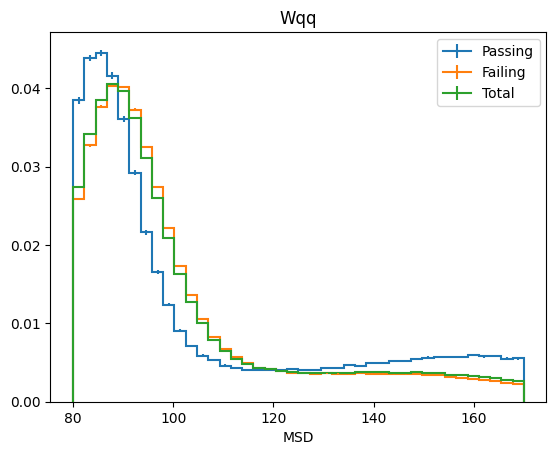

In [108]:
wqq_pass_hist.plot1d(density=True, label='Passing')
wqq_fail_hist.plot1d(density=True, label='Failing')
(wqq_pass_hist + wqq_fail_hist).plot1d(density=True, label='Total')
plt.title('Wqq')
plt.legend()
plt.show()

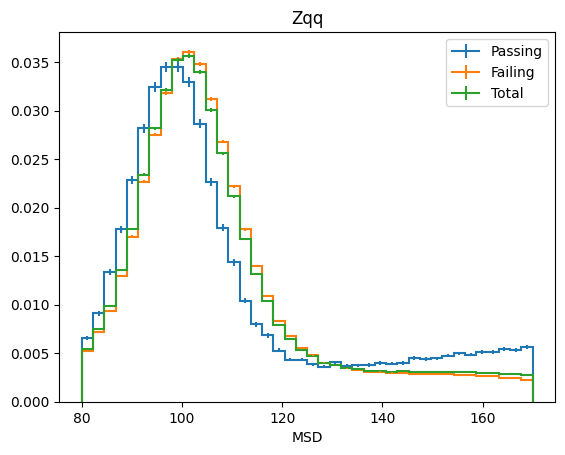

In [111]:
zqq_pass_hist.plot1d(density=True, label='Passing')
zqq_fail_hist.plot1d(density=True, label='Failing')
(zqq_pass_hist + zqq_fail_hist).plot1d(density=True, label='Total')
plt.title('Zqq')
plt.legend()
plt.show()

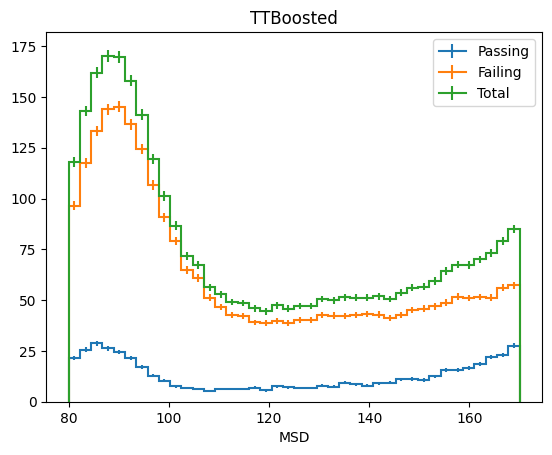

In [110]:
ttboosted_pass_hist.plot1d(density=False, label='Passing')
ttboosted_fail_hist.plot1d(density=False, label='Failing')
(ttboosted_pass_hist + ttboosted_fail_hist).plot1d(density=False, label='Total')
plt.title('TTBoosted')
plt.legend()
plt.show()

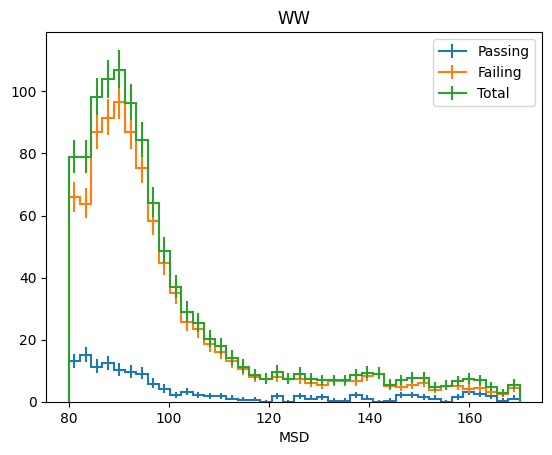

In [97]:
pass_hists['ww'].plot1d(density=False, label='Passing')
fail_hists['ww'].plot1d(density=False, label='Failing')
(fail_hists['ww'] + pass_hists['ww']).plot1d(density=False, label='Total')
plt.title('WW')
plt.legend()
plt.show()

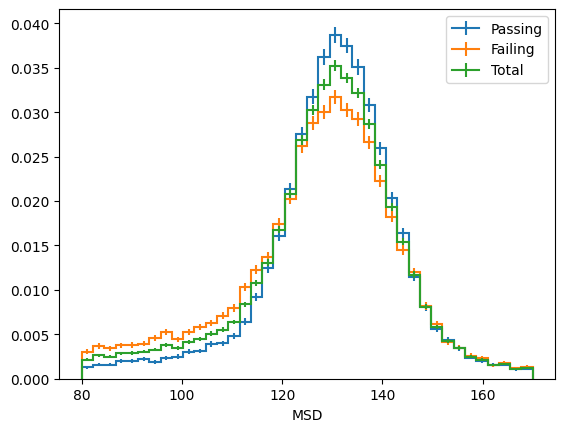

In [98]:
pass_hists['hgg'].plot1d(density=True, label='Passing')
fail_hists['hgg'].plot1d(density=True, label='Failing')
(pass_hists['hgg'] + fail_hists['hgg']).plot1d(density=True, label='Total')
plt.legend()
plt.show()

In [99]:
sum(pass_hists['hgg'].values()), sum(fail_hists['hgg'].values())

(15.48978167855305, 15.489058026056975)

In [100]:
for i in pass_hists:
    if (i == 'hgg') or (i == 'hbb'):
        continue
    else:
        with open(f'../output_hists/pass/hgg/hgg_vs_{i}_pass_cut_{cut:.3f}.pkl', 'wb') as f:
            pickle.dump(pass_hists[i], f)
with open(f'../output_hists/pass/hgg/hgg_pass_cut_{cut:.3f}.pkl', 'wb') as f:
    pickle.dump(pass_hists['hgg'], f)
with open(f'../output_hists/pass/hgg/hgg_vs_hbb_pass_cut_{cut:.3f}.pkl', 'wb') as f:
    pickle.dump(pass_hists['hbb'], f)

In [101]:
for i in fail_hists:
    if (i == 'hgg') or (i == 'hbb'):
        continue
    else:
        with open(f'../output_hists/fail/hgg/hgg_vs_{i}_fail_cut_{cut:.3f}.pkl', 'wb') as f:
            pickle.dump(fail_hists[i], f)
with open(f'../output_hists/fail/hgg/hgg_fail_cut_{cut:.3f}.pkl', 'wb') as f:
    pickle.dump(fail_hists['hgg'], f)
with open(f'../output_hists/fail/hgg/hgg_vs_hbb_fail_cut_{cut:.3f}.pkl', 'wb') as f:
    pickle.dump(fail_hists['hbb'], f)

In [102]:
pass_hists['qcd']

Hist(Regular(40, 80, 170, name='msd', label='MSD'), storage=Weight()) # Sum: WeightedSum(value=245.616, variance=0.262695)

In [103]:
fail_hists['qcd']

Hist(Regular(40, 80, 170, name='msd', label='MSD'), storage=Weight()) # Sum: WeightedSum(value=8.87273e+06, variance=9.01062e+07)

In [104]:
with open(f'../output_hists/fail/hgg/hgg_vs_qcd_fail_cut_0.412.pkl', 'rb') as f:
    a = pickle.load(f)

In [105]:
a

Hist(Regular(40, 80, 170, name='msd', label='MSD'), storage=Weight()) # Sum: WeightedSum(value=8.87273e+06, variance=9.01062e+07)

In [106]:
with open(f'../output_hists/pass/hgg/hgg_vs_qcd_pass_cut_0.412.pkl', 'rb') as f:
    a = pickle.load(f)

In [107]:
a

Hist(Regular(40, 80, 170, name='msd', label='MSD'), storage=Weight()) # Sum: WeightedSum(value=245.616, variance=0.262695)